# Système de vote à lots aléatoires :
Références:
- How To Hold A Vote When Candidates Are Too Many ? A Scalable And Random-Based Election.
*Guhur et al.*
- article Medium
- Git repository: https://github.com/plguhur/random-sets

## Introduction
Plus nombreux sont les candidats à se présenter à l'élection, et plus l'on peut s'attendre à un meilleur résultat. Dans la pratique, les systèmes de vote actuels ne le permettent pas, car plusieurs filtres (médias, notoriété, biais cognitifs) ne permettent qu'à une poignée de candidats d'émerger. 

Le vote à lots aléatoires résoud cette problématique, en ne demandant aux électeurs de ne voter que un lot de candidats. Les lots sont tirés aléatoirement pour chaque candidat, puis les votes sont agrégés. 

Pour que le résultat ne soit pas biaisé, on veut que le vote respecte trois critères :
1. Chaque candidat doit apparaitre autant de fois que les autres à une certaine marge d'erreur prête (il faut que le coefficient de variation du nombre d'apparition des candidats dans chaque lot soit inférieur à $\epsilon_1$).
2.	Chaque candidat doit être confronté autant de fois à n’importe quel autre candidat à une certaine marge d'erreur prête (il faut que le coefficient de variation du nombre d'opposition d'un candidat par rapport à un autre soit inférieur à $\epsilon_2$).
3.	Le résultat de l’élection doit être le même que si l’élection se déroulait selon des conditions parfaites (pas de manipulations, pas d’erreurs de partialité). Les différences de résultat dépendent du nombre $Nwinners$ de vainqueurs à l’élection : il n’y en a pas forcément qu’un seul, surtout dans le cas d’un second tour. On veut que l'erreur moyenne entre l'élection parfaite et l'élection à lots aléatoires soit inférieure à $\epsilon_3$.

On pose $\epsilon_i = 0.1$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import sys

L'algorithme pour construire les lots dépend de $\alpha$ :
1. compter le nombre d’occurences $Noccurences$ pour chaque candidat $i$ dans les lots précédents ;
2. construire un tableau qui attribut à candidat $i$ la valeur $1/Noccurences^\alpha$ si $Noccurences \neq 0$  et $1$ sinon ;
3. normaliser ce tableau en le divisant par la somme de chacune de ses cases ;
4. ce tableau forme la probabilité qu’à un candidat d’être choisi dans le prochain lot.

In [3]:
# this function builds a random subset
# occurrences must an np.array with dtype=float
def subset(Ncandidates, Nsubset, occurrences, alpha = 1.0):
    proba_candidat = np.array([1/(j**alpha) if j != 0 else 1 for j in occurrences])
    proba_candidat = proba_candidat / float(sum(proba_candidat))
    lot = np.random.choice(Ncandidates, size=Nsubset, replace=False, p=proba_candidat)
    occurrences[lot] += 1
    return lot

## Validation de la première condition
Voyons si la première condition est vérifiée en faisant varier le nombre d'électeurs et $\alpha$. $q$ est le pas d'échantillons.

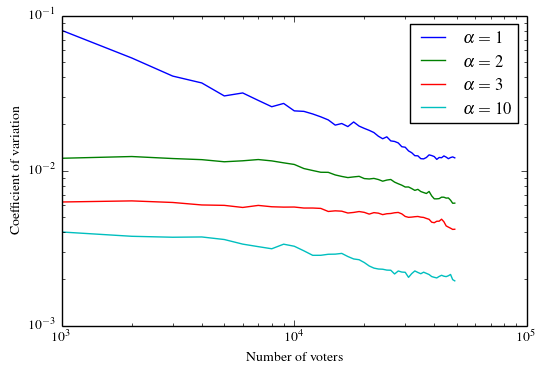

In [4]:
Ncandidates= 100
Nvoters = 50000
q  = 1000
alpha = [1, 2, 3, 10]
occurrences = np.zeros(Ncandidates, dtype=float)
rsm = np.zeros((int(Nvoters/q), len(alpha)))
Nsubset = 5
for j in range(len(alpha)):
    for i in range(Nvoters):
        lot = subset(Ncandidates, Nsubset, occurrences, alpha[j])
        if i % q == 0:
             rsm[int(i/q),j] = scipy.stats.variation(occurrences)
                
for j in range(len(alpha)):
    plt.loglog(range(q,Nvoters, q), rsm[1:, j],label="$\\alpha=%d$" % alpha[j])
plt.xlabel("Number of voters")
plt.ylabel("Coefficient of variation")
plt.legend()
plt.show()

Le coefficient de variation dépend également du nombre de candidats :

In [146]:
candidates= range(10,100, 10)
q  = 1000
voters = range(0,10001, q)
Nvoters = max(voters)
rsm = np.zeros((len(candidates), len(voters)))
Nsubset = 5
for j in range(len(candidates)):
    c = candidates[j]
    occurrences = np.zeros(candidates[j])
    for i in range(Nvoters+1):
        lot = subset(candidates[j], Nsubset, occurrences)
        if i % q == 0:
             rsm[j, int(i/q)] = scipy.stats.variation(occurrences)

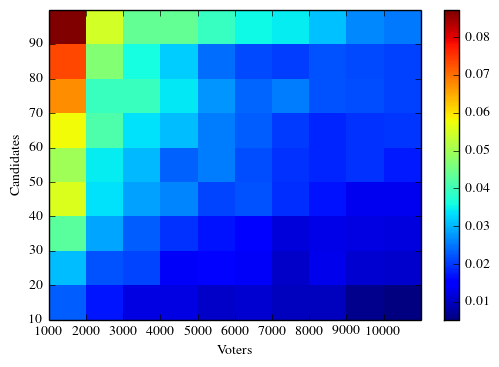

In [148]:
plt.pcolor(rsm[:,1:])
plt.colorbar()
plt.ylabel('Candidates')
plt.xlabel('Voters')
plt.yticks(range(len(candidates)), candidates)
plt.xticks(range(len(voters)), voters[1:])
plt.show()

Il faut donc aussi regarder comment varie le coefficient de variation avec le nombre de candidats et $\alpha$.

In [149]:
candidates= range(10,100, 20)
Ncandidates = max(candidates)
alphas = [1, 3, 10]
Nvoters = 10000
cv_alpha_c_1 = np.zeros((len(candidates), len(alphas)))
Nsubset = 5
for l in range(len(alphas)):
    for j in range(len(candidates)):
        occurrences = np.zeros(candidates[j])
        for i in range(Nvoters+1):
            lot = subset(candidates[j], Nsubset, occurrences, alphas[l])
        cv_alpha_c_1[j, l] = scipy.stats.variation(occurrences)

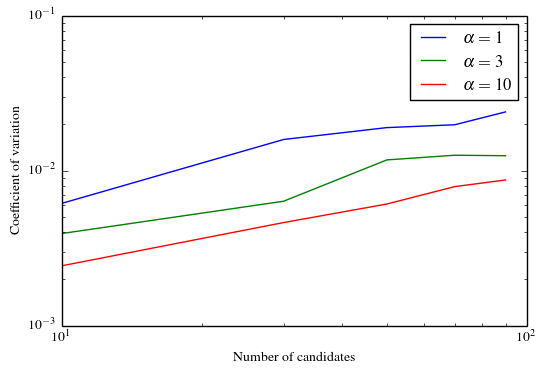

In [150]:
for j in range(len(alphas)):
    plt.loglog(candidates, cv_alpha_c_1[:, j],label="$\\alpha=%d$" % alphas[j])
plt.xlabel("Number of candidates")
plt.ylabel("Coefficient of variation")
plt.legend()
plt.show()

## Seconde condition
Concernant la seconde condition, on calcule la matrice $corr$ qui contient le nombre de fois qu'un candidat est opposé à un autre. Ici avec 100 candidats, $\alpha$=3 et 50k électeurs :

In [103]:
Nvoters = 50000
Ncandidates = 100
Nsubset = 5
alpha = 3
corr = np.zeros((Ncandidates,Ncandidates))
occurrences = np.zeros(Ncandidates)
for i in range(Nvoters):
        lot     = subset(Ncandidates, Nsubset, occurrences, alpha)
        for j in lot:
            corr[j,lot] += 1
            

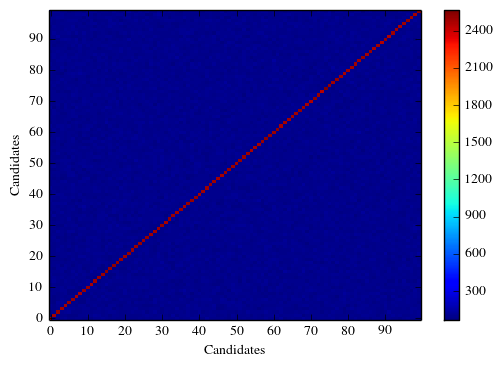

In [106]:
plt.pcolor(corr)
plt.colorbar()
plt.ylabel('Candidates')
plt.xlabel('Candidates')
plt.yticks(np.arange(0.5,Ncandidates + .5, 10),range(0,Ncandidates, 10))
plt.xticks(np.arange(0.5,Ncandidates + .5, 10),range(0,Ncandidates, 10))
plt.show()

La diagonale a les points les plus forts, car un candidat est sur de se rencontrer avec lui-même ! En revanche, le reste de la matrice semble bien uniforme. Regardons comment varie le  coefficient de variation entre deux candidats pour différents nombres d'électeurs et de candidats.

In [138]:
candidates= range(10,100, 10)
Ncandidates = max(candidates)
q  = 10000
voters = range(0,100001, q)
Nvoters = max(voters)
rsm = np.zeros((len(candidates), len(voters)))
Nsubset = 5
for j in range(len(candidates)):
    occurrences = np.zeros(candidates[j])
    corr = np.zeros((candidates[j],candidates[j]))
    for i in range(Nvoters+1):
        lot = subset(candidates[j], Nsubset, occurrences)
        for k in lot:
            corr[k,lot] += 1
        if i % q == 0:
            tri = corr[np.triu_indices(candidates[j], -1)]
            rsm[j, int(i/q)] = scipy.stats.variation(tri)

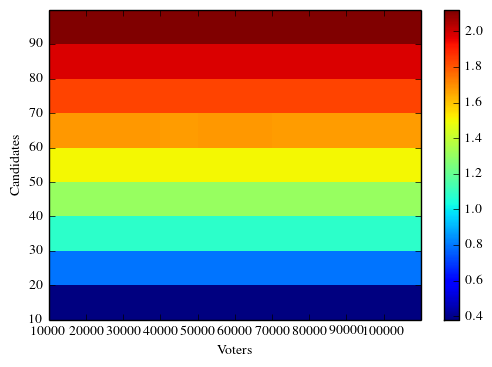

In [139]:
plt.pcolor(rsm[:,1:])
plt.colorbar()
plt.ylabel('Candidates')
plt.xlabel('Voters')
plt.yticks(range(len(candidates)), candidates)
plt.xticks(range(len(voters)), voters[1:])
plt.show()

On remarque que les variations du nombre d'électeurs sont négligeables devant les variations du nombre de candidats aux ordres de grandeurs choisis. Quel est l'impact de $\alpha$?

In [145]:
candidates= range(10,100, 10)
Ncandidates = max(candidates)
q  = 1000
alphas = [1, 3, 10]
Nvoters = 30000
rsm = np.zeros((len(candidates), len(alphas)))
Nsubset = 5
for l in range(len(alphas)):
    for j in range(len(candidates)):
        occurrences = np.zeros(candidates[j])
        corr = np.zeros((candidates[j],candidates[j]))
        for i in range(Nvoters+1):
            lot = subset(candidates[j], Nsubset, occurrences, alphas[l])
            for k in lot:
                corr[k,lot] += 1
        tri = corr[np.triu_indices(candidates[j], -1)]
        rsm[j, l] = scipy.stats.variation(tri)

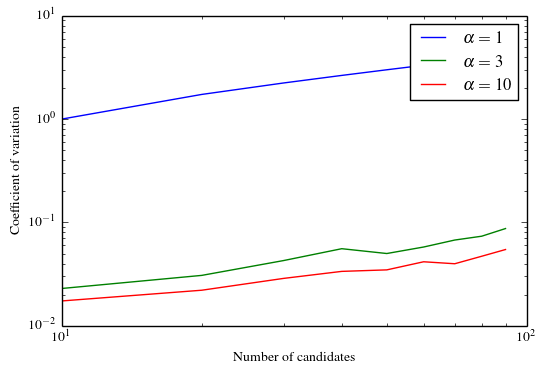

In [147]:
for j in range(len(alphas)):
    plt.loglog(candidates, rsm[:, j],label="$\\alpha=%d$" % alphas[j])
plt.xlabel("Number of candidates")
plt.ylabel("Coefficient of variation")
plt.legend()
plt.show()

In [158]:
Ncandidates = 50
q  = 1000
alphas = [1, 3, 10]
Nvoters = 30000
cv2_av = np.zeros((int(Nvoters/q)+1, len(alphas)))
Nsubset = 5
for l in range(len(alphas)):
    occurrences = np.zeros(Ncandidates)
    corr = np.zeros((Ncandidates,Ncandidates))
    for i in range(Nvoters+1):
        lot = subset(Ncandidates, Nsubset, occurrences, alphas[l])
        for k in lot:
            corr[k,lot] += 1
        if i % q == 0:
            tri = corr[np.triu_indices(Ncandidates, -1)]
            cv2_av[int(i/q),l] = scipy.stats.variation(tri)

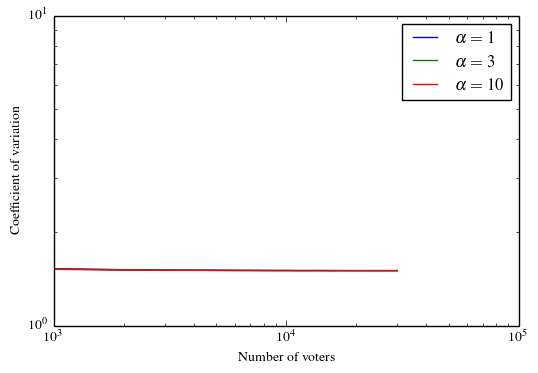

In [161]:
for j in range(len(alphas)):
    plt.loglog(range(q, Nvoters+1, q), cv2_av[1:, j],label="$\\alpha=%d$" % alphas[j])
plt.xlabel("Number of voters")
plt.ylabel("Coefficient of variation")
plt.legend()
plt.show()

On retrouve une faible variation du coefficient de variation lorsque le nombre de candidats, et ce pour différentes valeurs de $\alpha$. 

Finalement, on peut donc choisir $\alpha$ de sorte à respecter $\epsilon_1$ et $\epsilon_2$ selon un nombre fixé de candidats et d'électeurs. On veut également avoir $\alpha$ aussi faible que possible pour avoir la distribution la plus aléatoire possible. La fonction **findMinAlpha** calcule itérativement $\alpha$.

In [63]:
def findMinAlpha(Ncandidates, Nvoters, Ntests = 100, Nsubset = 5, q = 1, alphaMin = 1, epsilon1=0.1, epsilon2=0.1):
    alpha = alphaMin - q
    alpha_old = alpha
    error1 = epsilon1 + 1
    error2 = epsilon2 + 1
    
    while error1 > epsilon1 and error2 > epsilon2:
        alpha += q
        sys.stdout.write("\ralpha = %i is too low (error1 = %.4f and error2 = %.4f). Try with alpha = %i.\n" % (alpha_old, error1, error2, alpha))
        err_samples = np.zeros(Ntests, dtype=int)
        for t in range(Ntests):
            sys.stdout.write("\rTest: %i/%i (%i %%)" % (t+1, Ntests, float(t)/float(Ntests)*100.0))
            occurrences = np.zeros(Ncandidates)
            cv2_samples = np.zeros(Ntests)
            cv1_samples = np.zeros(Ntests)
            corr = np.zeros((Ncandidates,Ncandidates))
            for i in range(Nvoters+1):
                lot     = subset(Ncandidates, Nsubset, occurrences, alpha)
                for k in lot:
                    corr[k,lot] += 1
            tri = corr[np.triu_indices(Ncandidates, -1)]
            cv2_samples[t] = scipy.stats.variation(tri)
            cv1_samples[t] = scipy.stats.variation(occurrences)
        error1 = np.mean(cv1_samples, axis=0)
        error2 = np.mean(cv1_samples, axis=0)
        alpha_old = alpha
    sys.stdout.write("\n")
    return alpha 

In [64]:
alpha = findMinAlpha(200, 1000)
print("alpha = %i" % alpha)

alpha = 0 is too low (error1 = 1.1000 and error2 = 1.1000). Try with lpha = 1.
Test: 100/100 (99 %)1


## Troisième condition
On compare les résultats du vote avec un vote jugé idéal, ie. sans triches, ou biais.

Pour simuler un vote idéal, on démarre avec les résultats du jugement majoritaire d'OpinionWay/Terra Nova. En mesurant l'écart-type et la moyenne de ces résultats, on peut tirer les résultats de nouveaux candidats selon une loi gaussienne.

In [2]:
def vote(lot, proba, Nsubset, Ngrades):
    votes = np.zeros(Nsubset, dtype=int)
    for i in range(Nsubset):
        votes[i] = np.random.choice(range(Ngrades), size=1, replace=True, p=proba[i])
    return votes

def normalize(v, ax=1):
    n = np.sum(v, axis=ax)
    b = np.transpose(v)
    c = np.divide(b,n)
    return np.transpose(c)

def tieBreaking(A, B):
    #print str(A) + " " + str(B)
    Ac = np.copy(A)
    Bc = np.copy(B)
    medA = argMedian(Ac)
    medB = argMedian(Bc)
    while medA == medB:
        Ac[medA] -= 1
        Bc[medB] -= 1
        if not any(Ac):
            return -1
        if not any(Bc):
            return 1 
        medA = argMedian(Ac)
        medB = argMedian(Bc)
    return -1 if (medA < medB) else 1

def majorityJudgment(results):
    return sorted(range(len(results)), cmp=tieBreaking, key=results.__getitem__)

def probaCandidates(Ncandidates, Ngrades, inFile):
    """Read inFile. If there is not enough candidates, interpolate other. Save in outFile """
    inCandidates = np.genfromtxt(inFile, delimiter = " ", dtype=float)
    inCandidates = inCandidates[:,:Ngrades]
    Nc = len(inCandidates)
    N  = min(Nc, Ncandidates)
    param = np.zeros((Ngrades,2))
    param[:,0] = np.mean(inCandidates, axis=0)
    param[:,1] = np.std(inCandidates, axis=0)
    np.random.shuffle(inCandidates)
    outCandidates = np.zeros((Ncandidates,Ngrades))
    outCandidates[:N] = inCandidates[:N,:]
    if Ncandidates > Nc:
        for i in range(Ngrades):
            outCandidates[N:,i] = np.random.normal(param[i,0], param[i,1], Ncandidates-Nc)
    return normalize(np.absolute(outCandidates))

def argMedian(A):
    Ngrades = len(A)
    s   = np.array([sum(A[:i+1]) for i in range(Ngrades)])
    mid = float(s[Ngrades-1])/2
    return np.argwhere(mid < s)[0][0]
        

def rankError(rk_priori, rk_post, N):
    rk  = np.concatenate((rk_priori[:N], rk_post[:N]))
    return len(set(rk)) - N

Comme avec **findMinAlpha**, **findMinNvoters** cherche itérativement le nombre minimal d'électeurs qui permenttent d'atteindre $\epsilon_3$.

In [45]:
def findMinNvoters(Ncandidates, maxError = 0.1, Ntests = 100, Nwinner = 1, Nsubset = 5, Ngrades = 5, q = 1000, alpha = 1, real_results = "terranova.txt", epsilon=0.0):
    if epsilon == 0.0:
        epsilon = maxError/10 # not implemented yet
    maxTests = Ntests # max number of tests
    Nvoters = 0
    Nvoters_old = 0
    error = maxError + 1
    
    # perfect election
    pr_priori = probaCandidates(Ncandidates, Ngrades, real_results)
    res_priori = np.trunc(pr_priori*1000)
    rk_priori = majorityJudgment(res_priori)

    # election with random sets
    raw = np.zeros((Ntests, Ncandidates,Ngrades))
    occurrence = np.zeros((Ntests, Ncandidates))
    while error > maxError:
        Nvoters += q
        sys.stdout.write("\r%i voters is too low (%.4f > %.4f). Try with %i voters.\n" % (Nvoters_old, error, maxError, Nvoters))
        err_samples = np.zeros(Ntests, dtype=int)
        for t in range(Ntests):
            sys.stdout.write("\rTest: %i/%i (%i %%)" % (t+1, Ntests, float(t)/float(Ntests)*100.0))
            for i in range(Nvoters_old, Nvoters+1):
                lot     = subset(Ncandidates, Nsubset, occurrence[t], alpha)
                votes   = vote(lot, pr_priori[lot,:], Nsubset, Ngrades)
                raw[t,lot,votes] += 1
            results = normalize(raw[t])
            rk      = majorityJudgment(raw[t])
            err_samples[t] = rankError(rk_priori, rk, Nwinner)
        error = np.mean(err_samples, axis=0)
        Nvoters_old = Nvoters
    return Nvoters 

In [276]:
Nwinners = [1, 2, 5]
minNvoters_Nwinners = [findMinNvoters(10, q =1000, Nwinner = i) for i in Nwinners]
print minNvoters_Nwinners

[3000, 1000, 1000]


Ou, selon les paramètres du vote, on peut calculer l'erreur moyenne du vote avec **computeError**

In [49]:
def computeError(Ncandidates, Nvoters, maxError = 0.1, Nwinner = 1, Nsubset = 5, Ngrades = 5, alpha = 1, real_results = "terranova.txt", epsilon=0.0):
    if epsilon == 0.0:
        epsilon = maxError/10 # not implemented yet
    maxTests = 200 # max number of tests
    
    # perfect election
    pr_priori = probaCandidates(Ncandidates, Ngrades, real_results)
    res_priori = np.trunc(pr_priori*1000)
    rk_priori = majorityJudgment(res_priori)

    # election with random sets
    raw = np.zeros((maxTests, Ncandidates,Ngrades))
    occurrence = np.zeros((maxTests, Ncandidates))
    err_samples = np.zeros(maxTests, dtype=int)
    for t in range(maxTests):
        for i in range(Nvoters+1):
            lot     = subset(Ncandidates, Nsubset, occurrence[t], alpha)
            votes   = vote(lot, pr_priori[lot,:], Nsubset, Ngrades)
            raw[t,lot,votes] += 1
        results = normalize(raw[t])
        rk      = majorityJudgment(raw[t])
        err_samples[t] = rankError(rk_priori, rk, Nwinner)
    return np.mean(err_samples, axis=0)

In [284]:
print computeError(12, 10000, Nwinner = 5) #LaPrimaire.org

0.01
